In [2]:
import gdown
import pandas as pd

## Data Import

The following cells download raw datasets from cloud storage.
These are setup steps and not part of the analysis.


In [3]:
# @title
file_id = "1iFlv5PjnezdaCcTzWsjAX-Ck9kMCBMMK"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "orders.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1iFlv5PjnezdaCcTzWsjAX-Ck9kMCBMMK
From (redirected): https://drive.google.com/uc?id=1iFlv5PjnezdaCcTzWsjAX-Ck9kMCBMMK&confirm=t&uuid=13fc7b42-05bc-4383-9ffb-bff0d3b261f0
To: /content/orders.csv
100%|██████████| 377M/377M [00:18<00:00, 20.4MB/s]


'orders.csv'

In [4]:
file_id = "1o25JTcxDBEaigjCrdq_bzKb9BtzCZdy8"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "orderline.csv", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1o25JTcxDBEaigjCrdq_bzKb9BtzCZdy8
From (redirected): https://drive.google.com/uc?id=1o25JTcxDBEaigjCrdq_bzKb9BtzCZdy8&confirm=t&uuid=fc6ba49e-3814-4a19-91a1-734ab6d8c16d
To: /content/orderline.csv
100%|██████████| 642M/642M [00:09<00:00, 67.4MB/s]


'orderline.csv'

In [5]:
file_id = "1Aa5oSSE-3Fn6RQpupqcg2sAf3l2VlccA"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "person.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1Aa5oSSE-3Fn6RQpupqcg2sAf3l2VlccA
To: /content/person.csv
100%|██████████| 83.3M/83.3M [00:02<00:00, 31.6MB/s]


'person.csv'

In [6]:
file_id = "1dL388NuXzV8mpTJ44HEmp2LgxKR1d4z8"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "product.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1dL388NuXzV8mpTJ44HEmp2LgxKR1d4z8
To: /content/product.csv
100%|██████████| 1.75M/1.75M [00:00<00:00, 55.6MB/s]


'product.csv'

## Dataset Size Overview

Before starting the analysis, I checked the size of each table to understand the scale of the data and decide where aggregations would be necessary.

Given the large number of order-line records compared to orders and customers, most revenue-related analysis is performed at the order-line level to avoid loss of detail.

In [8]:
df_person = pd.read_csv("person.csv", sep=";")
df_orders = pd.read_csv("orders.csv", sep=";")
df_orderline = pd.read_csv("orderline.csv", sep=";")
df_product = pd.read_csv("product.csv", sep=";")

In [9]:
print("Person:", df_person.shape)
print("Orders:", df_orders.shape)
print("Orderline:", df_orderline.shape)
print("Product:", df_product.shape)

Person: (600000, 12)
Orders: (5000000, 8)
Orderline: (13000000, 8)
Product: (8000, 18)


I briefly reviewed the product schema to confirm category-level fields were available for aggregation.

In [10]:
df_product.columns

Index(['product_id', 'sku', 'name', 'description', 'category', 'subcategory',
       'brand', 'price', 'cost', 'stock_quantity', 'weight_kg', 'length_cm',
       'width_cm', 'height_cm', 'status', 'created_date', 'rating_average',
       'review_count'],
      dtype='object')

At this stage, no data cleaning was required as IDs and categorical fields were already well structured.

In [11]:
df_person.head(2)
df_orders.head(2)
df_orderline.head(2)
df_product.head(2)

,product_id,sku,name,description,category,subcategory,brand,price,cost,stock_quantity,weight_kg,length_cm,width_cm,height_cm,status,created_date,rating_average,review_count
0,1,PRD-KMQL4V-KEE,Cutting Monitor Deluxe,Trendy design reflecting current market trends,Mobile Devices,RidOns,RoastRoyal,181.95,79.95,440,43.46,76.0,120.5,65.6,active,2022-08-07,1.1,4242
1,2,PRD-VD0TAJ-NBG,Elite Phablet v3,Elegant aesthetics with minimalist approach,Reference,Utensils,CableConnect,564.95,857.95,177,14.46,112.9,137.6,67.9,active,2024-11-01,4.7,3981


#Data integrity checks
Verified primary keys and foreign key relationships across tables.
All relationships are valid.


In [12]:
df_person['person_id'].is_unique
df_orders['order_id'].is_unique
df_product['product_id'].is_unique

True

In [13]:
df_orders['person_id'].isin(df_person['person_id']).mean()
df_orderline['order_id'].isin(df_orders['order_id']).mean()
df_orderline['product_id'].isin(df_product['product_id']).mean()

np.float64(1.0)

In [14]:
df_orders['status'].value_counts()
df_orderline['status'].value_counts()

,count
status,
fulfilled,2602356
cancelled,2600481
returned,2599406
pending,2599167
shipped,2598590


In [15]:
success_lines = ['fulfilled']
loss_lines = ['returned']   # NOT cancelled

In [16]:
delivered_revenue = df_orderline.loc[
    df_orderline['status'].isin(success_lines),
    'subtotal'
].sum()

In [17]:
lost_revenue = df_orderline.loc[
    df_orderline['status'].isin(loss_lines),
    'subtotal'
].sum()

In [18]:
GOV = df_orderline['subtotal'].sum()

In [19]:
NRR = delivered_revenue - lost_revenue
fulfillment_efficiency = NRR / GOV
print(NRR)
print(fulfillment_efficiency)

10433400.990003586
0.00014825130582453696


## Fulfillment Efficiency Calculation

Fulfillment Efficiency was calculated at the order-line level to ensure consistency in revenue measurement.

- Delivered Revenue was defined as the sum of subtotals for fulfilled items.
- Revenue Loss was defined as the sum of subtotals for returned items only.
- Cancelled items were excluded from revenue loss, as they do not represent realized revenue.

Net Realized Revenue (NRR) was calculated as:

NRR = Delivered Revenue − Returned Revenue

Fulfillment Efficiency was then computed as:

Fulfillment Efficiency = NRR ÷ Gross Order Value (GOV)

This approach ensures alignment with real-world e-commerce revenue accounting.


In [20]:
df_combined = (
    df_orderline
    .merge(
        df_product[['product_id', 'category']],
        on='product_id',
        how='left'
    )
)


In [21]:
success_lines = ['fulfilled']
loss_lines = ['returned']

In [22]:
category_summary = df_combined.groupby('category').agg(
    GOV=('subtotal', 'sum'),
    Delivered=('subtotal', lambda x: x[df_combined.loc[x.index, 'status'].isin(success_lines)].sum()),
    Returned=('subtotal', lambda x: x[df_combined.loc[x.index, 'status'].isin(loss_lines)].sum())
)

In [23]:
category_summary['NRR'] = (
    category_summary['Delivered'] - category_summary['Returned']
)

category_summary['Fulfillment_Efficiency'] = (
    category_summary['NRR'] / category_summary['GOV']
)

In [24]:
category_summary.sort_values('Fulfillment_Efficiency')

,GOV,Delivered,Returned,NRR,Fulfillment_Efficiency
category,,,,,
Beverages,1.472792e+09,2.925245e+08,2.977884e+08,-5263950.90,-0.003574
Gaming,1.364663e+09,2.708127e+08,2.747989e+08,-3986151.85,-0.002921
Kitchenware,1.174737e+09,2.326127e+08,2.356252e+08,-3012466.34,-0.002564
Automotive,1.237309e+09,2.449236e+08,2.480962e+08,-3172630.25,-0.002564
Reference,1.164652e+09,2.314727e+08,2.341926e+08,-2719879.18,-0.002335
Car Electronics,1.259669e+09,2.518688e+08,2.545248e+08,-2655997.69,-0.002108
Health,1.371456e+09,2.738700e+08,2.761382e+08,-2268175.05,-0.001654
Audiobooks,1.510470e+09,3.007802e+08,3.029629e+08,-2182665.71,-0.001445
Computing,1.534296e+09,3.069052e+08,3.088030e+08,-1897846.56,-0.001237


"Several categories show negative fulfillment efficiency due to return volumes exceeding fulfilled revenue. This indicates operational or product-level issues such as high return rates, customer dissatisfaction, or fragile logistics in those categories."

In [25]:
category_summary['Return_Rate'] = (
    category_summary['Returned'] /
    (category_summary['Delivered'] + category_summary['Returned'])
)

In [27]:
category_summary.sort_values('Return_Rate', ascending=False)

,GOV,Delivered,Returned,NRR,Fulfillment_Efficiency,Return_Rate
category,,,,,,
Beverages,1.472792e+09,2.925245e+08,2.977884e+08,-5263950.90,-0.003574,0.504459
Gaming,1.364663e+09,2.708127e+08,2.747989e+08,-3986151.85,-0.002921,0.503653
Automotive,1.237309e+09,2.449236e+08,2.480962e+08,-3172630.25,-0.002564,0.503218
Kitchenware,1.174737e+09,2.326127e+08,2.356252e+08,-3012466.34,-0.002564,0.503217
Reference,1.164652e+09,2.314727e+08,2.341926e+08,-2719879.18,-0.002335,0.502920
Car Electronics,1.259669e+09,2.518688e+08,2.545248e+08,-2655997.69,-0.002108,0.502622
Health,1.371456e+09,2.738700e+08,2.761382e+08,-2268175.05,-0.001654,0.502062
Audiobooks,1.510470e+09,3.007802e+08,3.029629e+08,-2182665.71,-0.001445,0.501808
Computing,1.534296e+09,3.069052e+08,3.088030e+08,-1897846.56,-0.001237,0.501541


In [29]:
category_summary['Attractiveness_Score'] = (
    category_summary['Fulfillment_Efficiency'] *
    (1 - category_summary['Return_Rate'])
)

category_summary.sort_values('Attractiveness_Score', ascending=False)

,GOV,Delivered,Returned,NRR,Fulfillment_Efficiency,Return_Rate,Attractiveness_Score
category,,,,,,,
Kitchen Appliances,1.514319e+09,3.068404e+08,3.013048e+08,5535605.36,0.003656,0.495449,0.001844
Cameras,1.445154e+09,2.919481e+08,2.867818e+08,5166293.76,0.003575,0.495537,0.001803
Bathroom,1.329486e+09,2.683279e+08,2.643695e+08,3958355.63,0.002977,0.496285,0.001500
Puzzles,1.344839e+09,2.705929e+08,2.667136e+08,3879371.29,0.002885,0.496390,0.001453
Childrens Clothing,1.288510e+09,2.605645e+08,2.574283e+08,3136137.70,0.002434,0.496973,0.001224
Cycling,1.349747e+09,2.713338e+08,2.688783e+08,2455439.20,0.001819,0.497727,0.000914
Haircare,1.182787e+09,2.377162e+08,2.356980e+08,2018167.42,0.001706,0.497868,0.000857
Mens Fashion,1.478890e+09,2.969439e+08,2.946242e+08,2319694.33,0.001569,0.498039,0.000787
Formal Wear,1.299332e+09,2.607218e+08,2.587700e+08,1951711.09,0.001502,0.498122,0.000754


<Axes: xlabel='category'>

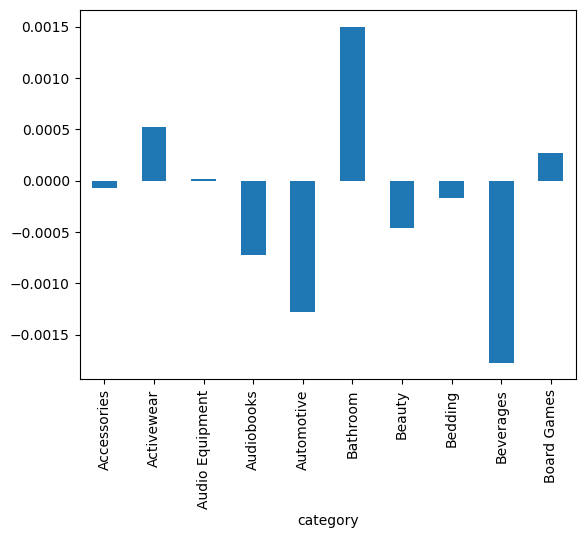

In [30]:
category_summary.head(10)['Attractiveness_Score'].plot(kind='bar')